#  **DBN on EMNIST dataset**

> Student: Sara Kartalovic<br>
> Date: 18/01/22 <br>
> Course : Cognition and Computation <br>
> Teachers : Marco Zorzi and Alberto Testolin <br>



# Introduction

In this project, I will explore Deep Belief Networks (DBN) which components are two or more Restricted Boltzmann Machines(RBM). The data set that will be used is EMNIST. In particular, I will use the balanced version while testing the models since it is the most applicable. Firstly, the dataset will be explored with two different dimensionality reduction techniques for representing multi-dimensional data to make better sense of data. Then, the experiment will continue with exploring different parameters of DBN and continue with the development of a deeper version. After finding the most suitable model, the internal representation developed by the model will be analyzed by studying the feature visualization and hierarchical clustering. Next, the linear read-outs will be performed at different levels of the model to discover if the representations develop into less entangled at the deepest stages in the network. In the end, the model will be evaluated, the accuracy will be computed and the confusion matrix will be analyzed in order to determine the type of the errors that model made.

In [ ]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [ ]:
%%capture
get_dbn_library()

In [ ]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import scipy.cluster as cluster
import torch
import torchvision as tv

from DBN import DBN

from sklearn import decomposition
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
import itertools

Functions used in the project

In [ ]:
def _move_parameters_to_cpu(dbn_mnist):
  for layer in dbn_mnist.rbm_layers:
    layer.W = layer.W.cpu()
    layer.h_bias = layer.h_bias.cpu()
    layer.v_bias = layer.v_bias.cpu()

def _apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)

def _plot_layer_receptive_fields(weights):
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot

def _get_kth_layer_repr(input, k):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor)
  hidden_repr, __ = dbn_emnist.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

def _get_mask(label):  # we use this function to filter by class
  labels = emnist_targets_train.numpy()
  return labels == label

def _get_label_to_mean_hidd_repr(hidden_representation):
  hidden_representation_np = hidden_representation.numpy()
  return {
    label: hidden_representation_np[_get_mask(label)].mean(axis=0)  # here we filter by class and compute the mean
    for label in range(47)
  }

def _get_hidden_reprs_matrix(label_to_mean_hidd_repr):  # we use this to build the matrices
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in range(47)])

def _plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots(figsize=(20, 5))
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  dendrogram = cluster.hierarchy.dendrogram(linkage)
  ax.set_title(title)

def _compute_accuracy(predictions, targets):
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == emnist_targets_test).sum() / len(emnist_targets_test)
  return accuracy.item()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.rcParams["figure.figsize"] = (50,50)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Dataset

The EMNIST dataset contains handwritten characters and digits derived from the NIST Special Database 19. There are 47 balanced classes which include 10 digits and lowercase and uppercase letters. Images are converted to 28x28 pixel image format where each pixel stores a unique value. Each of these values corresponds to a grayscale level in the pixel. The grayscale values for each pixel are between 0 and 255 for each of the images. Because of this, the images will be normalized to a scale between 0 and 1.

The dataset is separated into 6 different groups: ByClass(default), ByMerge, Balanced, Digits, Letters, and EMNIST MNIST. In this project, I will focus on the "Balanced" dataset which has an equal number of samples per class. A balanced dataset was made after the ByMerge dataset to reduce miss-classification errors due to capital and lower case letters. Model is trained on a much larger train dataset (102,800 samples), while its accuracy and loss are approximated on the smaller test set (10000 samples) because that way it can be seen how the model behaves with the unseen data. In this project, the model will learn representation from the train set, and after creating representations on the test set classification will be performed. The labels are used for analyzing the model because here we have the case of unsupervised learning, so labels are not needed for the training procedure.

Loading the EMNIST dataset

In [ ]:
%%capture
emnist_data = tv.datasets.EMNIST(root='./emnist_data/', split = 'balanced', train=True, download=True,
                            transform=tv.transforms.Compose(
                                            [tv.transforms.ToTensor(),
                                             tv.transforms.Normalize((0.1307,), (0.3081,))]
                                             ))

In [ ]:
# Normalization of the datasets

emnist_data.data = (emnist_data.data.type(torch.FloatTensor)/255)

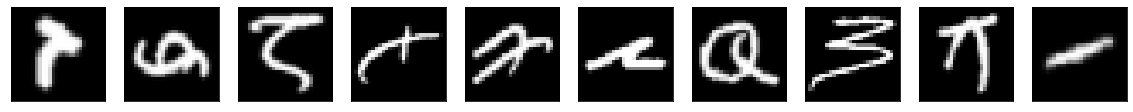

In [ ]:
# Plot 10 samples of the data

plt.figure(figsize=(20, 4))
for i in range(10):
  ax = plt.subplot(1, 10, i + 1)
  plt.imshow(emnist_data.data[i])
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

The image shown is in the class: 13


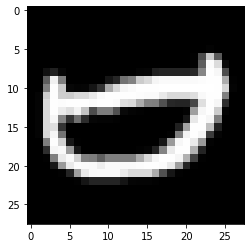

In [ ]:
# plot sample and its lable
i = 13
print("The image shown is in the class: {}".format(emnist_data.targets[i]) )
plt.imshow(emnist_data.data[i] , cmap = 'gray')
plt.show()

In [ ]:
# Split the dataset intro train and test sets

emnist_data_train = emnist_data.data[10000:, :]
emnist_targets_train = emnist_data.targets[10000:]

emnist_data_test = emnist_data.data[:10000, :]
emnist_targets_test = emnist_data.targets[:10000]

print("Shape of the EMNIST balanced train set: ", emnist_data_train.shape)
print("Shape of the EMNIST balanced test set: ", emnist_data_test.shape)

Shape of the EMNIST balanced train set:  torch.Size([102800, 28, 28])
Shape of the EMNIST balanced test set:  torch.Size([10000, 28, 28])


## PCA

Principle Component Analysis (PCA) is a linear method that is used for dimensionality reduction of large datasets. The dimensionality reduction is done by transforming an extensive set of variables into a smaller set. This smaller set will contain most of the information that a large dataset contains. Dimensionality reduction can cause accuracy decrease; however, analyzing and visualizing smaller datasets make their exploration much easier. </br></br>

With the EMNIST dataset, the dimensionality is drastically reduced from 784 to 2 which is specified by the n_components parameter. The PCA provided us with the 2 linear combinations of the original 784 variables that maximize the total variance of the dataset and is with mixed results. In the plot below, we can see some distinct clusters even though they are overlapping. The balanced dataset has 47 classes, so there is a lot of overlap between the clusters in the plot because some elements from different classes have very similar features. Furthermore, it is shown that some classes are played out all over the plots.

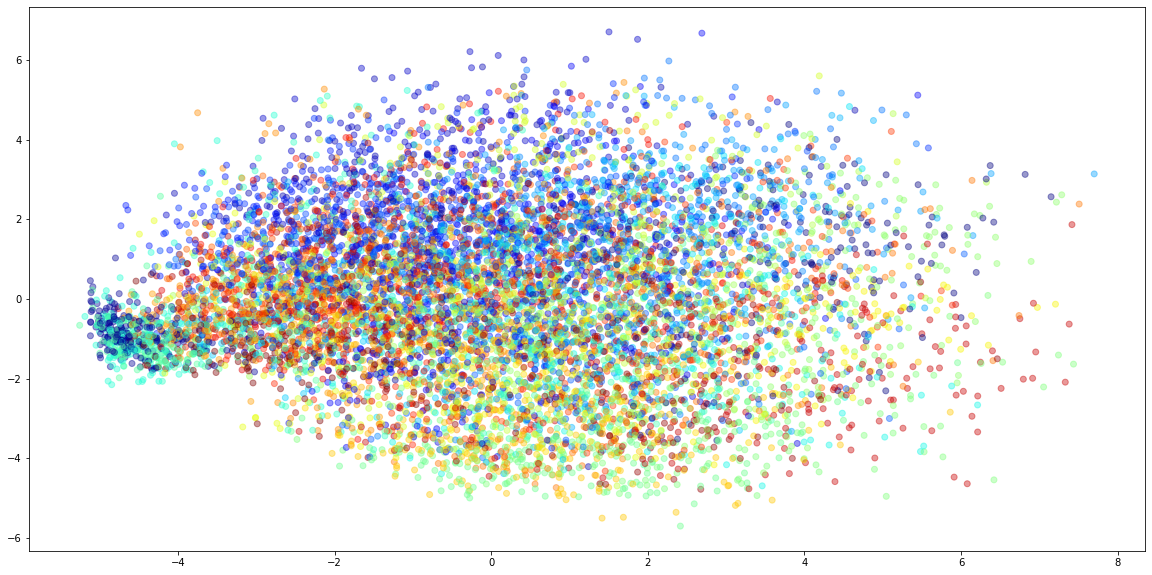

In [ ]:
# PCA of balanced dataset

balanced = emnist_data_train.reshape((len(emnist_data_train), np.prod(emnist_data_train.shape[1:])))

plt.figure(figsize=(20,10))
pca = decomposition.PCA(n_components=2)
view = pca.fit_transform(balanced[:10000])
plt.scatter(view[:,0], view[:,1], c=emnist_targets_train[:10000], alpha=0.4, cmap=plt.cm.jet)

## t-SNE

t-Distributed Stochastic Neighbor Embedding (t-SNE) is an unsupervised and non-linear dimensionality reduction algorithm based on probability distribution with a random walk on neighborhood graphs that is able to find the low-dimensional manifolds in the original high-dimensional space. It was invented by van der Maaten and Hinton and attempts to preserve the topology of the original space. This algorithm is used for exploring high-dimensional data and can project manifolds from high-dimensional space in a destination space of much lower dimension. Since it maps the high-dimensional data to, usually, 2 or 3 dimensions, it makes it more fitting for humans to observe.<br><br>

If we randomly pick a point in the original high-dimensional space, we would get just a random pixel or some noise because the space is mostly empty. The assumption is that the images are in the manifolds of lower dimensions and curve like ribbons in the high-dimensional space. With this being said, it is also believed that images occupy a limited part of the original high-dimensional space. If the assumption is correct, then the items of one class would be located in the same ribbon. The problem comes from the fact that ribbons can be placed in different locations. So our PCA will show a cluster only if the ribbon is located in a corner of high-dimensional space. However, if this is not the case, PCA will not make the high-dimensional data more understandable and this is the moment when we can try using t-SNE.<br><br>

When applying t-SNE to the EMNIST dataset, we reduce 784-dimensional space to 2-dimensional which is described by the n_components parameter. Even though clusters are still intricated, t-SNE gave a better plot with much more distinctive clusters. The reason why classes are intricated may be that the comparable manifolds are very close to each other in the high-dimensional space.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Text(0, 0.5, 't-SNE-2')

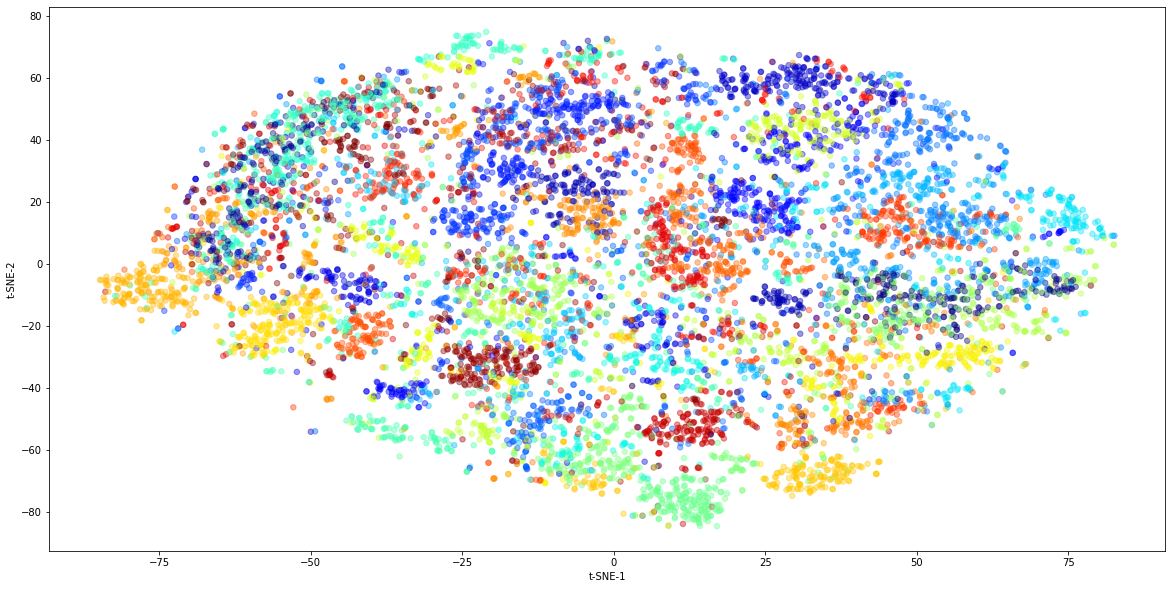

In [ ]:
view = TSNE(n_components=2, random_state=123).fit_transform(balanced[:10000])

plt.figure(figsize=(20,10))
plt.scatter(view[:,0], view[:,1], c=emnist_targets_train[:10000], alpha=0.4, cmap=plt.cm.jet, s=30)
plt.xlabel('t-SNE-1')
plt.ylabel('t-SNE-2')

# DBN

DBNs are unsupervised machine learning models that can be seen as the chain of the RBMs. RBMs take a probabilistic approach for neural networks and are composed of 3 parts: visible unit (input layer), hidden unit (hidden layer), and bias unit. Its goal is to reconstruct the original image with its hidden layer representation. Since the RBMS are stacked one after another, when the first RBM finishes the image reconstruction process, a new RBM is created which as input uses the hidden layer representation from the previous layer. DBNs learn probability distribution that possibly generates the input data during the training phase. The models are trained using the 'contrastive divergence" which is an algorithm whose main objective is to decrease the difference between the true and learned probability distributions. <br><br>

To find the model with the best performance, there were 5 experiments:

1.  Different numbers of hidden layers
2.  Different learning rates
3.  Different initial momentum
4.  Different Final momentum
5.  The number of hidden units

All models were trained for 50 epochs using the training dataset, which means that each layer was trained for 50 epochs separately. Also, all models were trained using the batch_size of 100. The learning rate was constant at all times, which was set by the learning_rate_decay parameter, while the weigth_decay parameter was set to a very low value to preserve some parts of the previous updates and weights.

## Experiments

Firstly, I started developing deeper models while monitoring the accuracy of the perceptron that was trained using the last hidden layer representations. I decided to try deeper models because there are a lot of classes so I assumed that deeper models would perform better. The highest **accuracy** of **65.89%** was obtained when using **5 layers** which is shown in the table below, so I decided to proceed with this model.   

| # hidden layers         | Accuracy |
|-------------------------|----------|
| 1 [500]                 | 0.6357   |
| 2 [500, 500]            | 0.6403   |
| 3 [500,500,500]         | 0.6540   |
| 4 [500,500,500,500]     | 0.6374   |
| 5 [500,500,500,500,500] | **0.6589**   |


<br>

________________________________________________________________________________
<br>

After deciding to use the model with 5 hidden layers, I wanted to see if changing the learning rate would increase accuracy. As shown in the table below, with a higher learning rate, the accuracy is higher so I chose to use **learning rate** of **0.1**.  

| Learning Rate | Accuracy |
|---------------|----------|
| 0.1           | **0.6589**   |
| 0.01          | 0.6466   |
| 0.001         | 0.6349   |

<br>

________________________________________________________________________________
<br>

Next, I proceeded with testing different initial and final momentums as shown in the table below while monitoring the accuracy and loss of the last hidden layer when performing classification tasks. The highest accuracy and lowest loss were obtained when using **initial momentum** of **0.4** and **final momentum** of **0.9**.


| Initial Momentul | Accuracy | Loss   | ||| Final Momentum | Accuracy | Loss   |
|------------------|----------|--------| |||----------------|----------|--------|
| 0.5              | 0.6589   | 1.3234 | ||| 0.9            | **0.6643**   | **1.3159** |
| 0.4              | **0.6643**   | **1.3159** | ||| 0.8            | 0.6529   | 1.3139 |
| 0.3              | 0.6610   | 1.3317 | ||| 0.7            | 0.6552   | 1.3011 |

<br>

________________________________________________________________________________
<br>

Lastly, I try a different number of neurons at different levels of the model as shown in the table. The model that showed improvement when it comes to both accuracy and loss is the one using **1000,1000,900,700,** and **700 neurons**. The **highest accuracy** obtained by the model on the classification task was **67.85%** while the **lowest loss** was **1.2722**.

| # hidden units          | accuracy | loss    |
|-------------------------|----------|---------|
| [500,500,500,500,500]   | 0.6643   | 1.3159  |
| [700,700,700,700,700]   | 0.6714   | 1.2822  |
| [900,700,700,500,500]   | 0.6675   | 1.3041  |
| [900,900,700,700,700]   | 0.6752   | 1.2770  |
| [900,900,900,700,700]   | 0.6757   | 1.2733  |
| [900,900,900,900,900]   | 0.6750   | 1.28009 |
| [1000,900,900,700,700]  | 0.6749   | 1.2737  |
| [1000,1000,900,700,700] | **0.6785**   | **1.2722** |
| [1000,900,700,500,500]  | 0.6690   | 1.3040  |












In [ ]:
# Create DBN

dbn_emnist = DBN(visible_units=28*28,
                hidden_units=[1000,1000,900,700,700],
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.4,
                final_momentum=0.9,
                weight_decay=0.00002,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=True)

In [ ]:
# Training DBN

num_epochs = 50
batch_size = 100

history = dbn_emnist.train_static(
    emnist_data_train,
    emnist_targets_train,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.9979   |0.0315   |411.1708 |7.8599   |
|20    |0.9316   |0.0286   |376.8526 |5.9679   |
|30    |0.9138   |0.0277   |370.4928 |6.0780   |
|40    |0.9035   |0.0271   |369.5370 |6.0700   |
|50    |0.8977   |0.0276   |369.9153 |5.8165   |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.5531   |0.0160   |316.3299 |4.2719   |
|20    |0.5173   |0.0147   |305.4304 |3.9943   |
|30    |0.5109   |0.0144   |304.8919 |3.6974   |
|40    |0.5072   |0.0149   |304.4816 |3.7499   |
|50    |0.5050   |0.0144   |305.1352 |4.0821   |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.5273   |0.0167   |279.3353 |4.6207   |
|20    |0.4814   |0.0147   |255.5946 |3.7080   |
|30    |0.4673   |0.0142   |251.0545 |3.8168   |
|40    |0.4597   |0.0144   |249.2705 |3.4530   |
|50    |0.4541

## Visualizing Receptive Fields


By visualizing the learned weights at the different levels it is possible to see what parts of the particular image trigger the unit represented by a specific vector. So we are looking what are the pixels that activate the neurons in our model. Each of the 100 squares represents the output of the hidden layers and it is expected to detect some features at deeper levels of the model. In order to exclude the noise in the plots, the threshold will be used on the learned weights.

<br>

It is important to understand that only the first layer as input has 28x28 (784) pixels images, while others take as the input the hidden representation from the previously hidden layer. So our second layer weights will have the shape of 1000x1000 because there are 1000 elements of the second layer connected to the 1000 nodes from the first layer. More precisely, the third hidden layer will have a dimensionality of 1000x900, the fourth layer's shape would be 900x700 whereas the last layer has the shape of 700x700. To visualize images, each of the wight's vectors needs to be projected in the dimensionality 28x28 (784).

<br>

Even though we are looking at images, what we are seeing here are the connection strengths. The white and black colors represent positive and negative weights respectively, while grey is 0 and represents noise. Different thresholds were tried on in order to isolate as much noise as possible such as 0.1, 0.05, 0.5, and 0.01. The first layer seems to have the best results when the threshold is 0.1, while for other layers seems to be no difference when the threshold is applied.

<br>

The dots that represent weights are related to a specific pixel point in the image, while short lines are related to strokes. The first, third, and fifth layers are somewhat similar because there are a lot of dots and lines like strokes. This shows that neurons were activated by very simple features mostly. Besides dots and strokes, there are also a few curves, which are more defined on the last hidden layer. On the second and fourth layers, there are a lot of black images which indicate that the weights are negative. There is also a lot of noise on the second layer, and applying different thresholds did not seem to give better representations.

In [ ]:
_move_parameters_to_cpu(dbn_emnist)

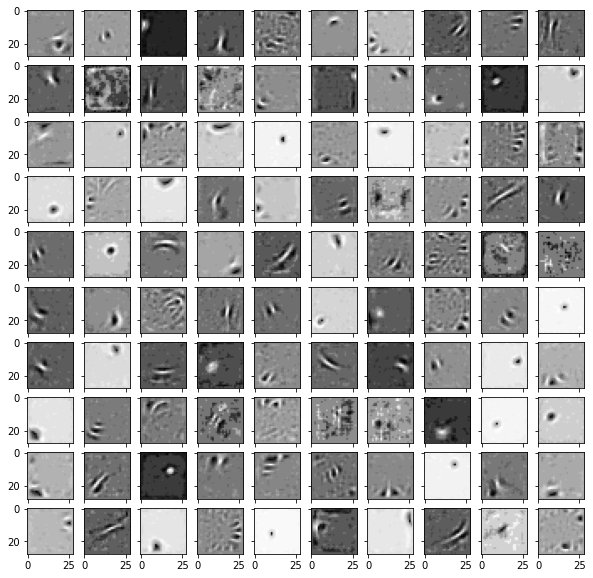

In [ ]:
# Print weights layer 1

#Extract weigths
learned_weights_layer_1 = dbn_emnist.rbm_layers[0].W.transpose(0,1).numpy()

# Apply threshold to eliminate noise
learned_weights_layer_1 = _apply_threshold(learned_weights_layer_1, .1)         # Check different thresholds

_plot_layer_receptive_fields(learned_weights_layer_1)

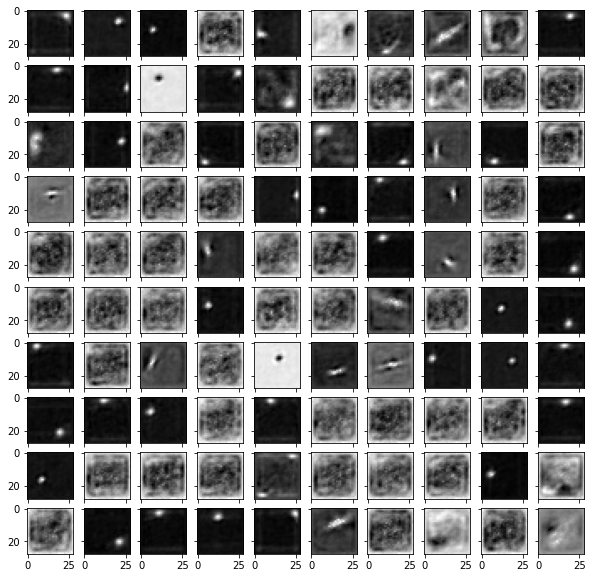

In [ ]:
# Print weights layer 2

#Extract weigths
learned_weights_layer_1 = dbn_emnist.rbm_layers[0].W.numpy()
learned_weights_layer_2 = dbn_emnist.rbm_layers[1].W.numpy()

# Apply threshold to eliminate noise
learned_weights_layer_1 = _apply_threshold(learned_weights_layer_1, 0)
learned_weights_layer_2 = _apply_threshold(learned_weights_layer_2, 0)

# Project back matrix in 28x28 space
learned_weights_product = (learned_weights_layer_1 @ learned_weights_layer_2).T # here we do the projection
learned_weights_product = _apply_threshold(learned_weights_product, 0)

_plot_layer_receptive_fields(learned_weights_product)

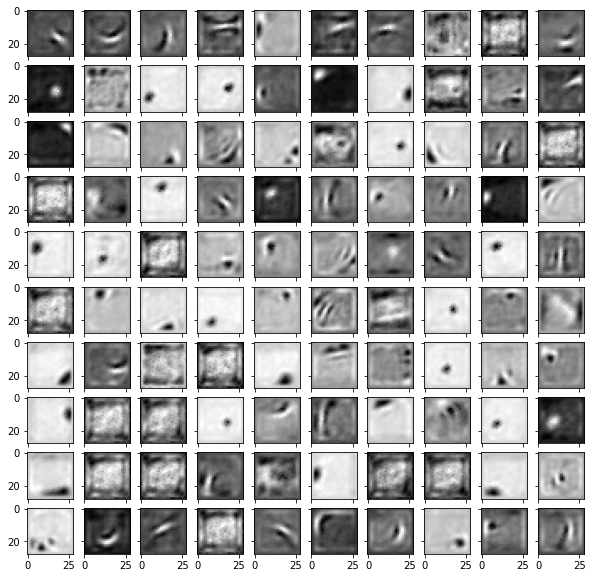

In [ ]:
# Print weights layer 3

#Extract weigths
learned_weights_layer_1 = dbn_emnist.rbm_layers[0].W.numpy()
learned_weights_layer_2 = dbn_emnist.rbm_layers[1].W.numpy()
learned_weights_layer_3 = dbn_emnist.rbm_layers[2].W.numpy()

# Apply threshold to eliminate noise
learned_weights_layer_1 = _apply_threshold(learned_weights_layer_1, 0)
learned_weights_layer_2 = _apply_threshold(learned_weights_layer_2, 0)
learned_weights_layer_3 = _apply_threshold(learned_weights_layer_3, 0)

# Project back matrix in 28x28 space
learned_weights_product = (learned_weights_layer_1 @ learned_weights_layer_2 @ learned_weights_layer_3).T  # here we do the projection
learned_weights_product = _apply_threshold(learned_weights_product, 0)

_plot_layer_receptive_fields(learned_weights_product)

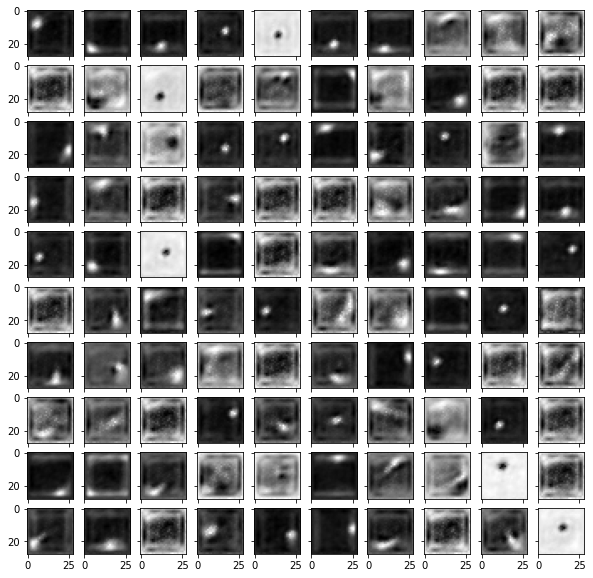

In [ ]:
# Print weights layer 4

#Extract weigths
learned_weights_layer_1 = dbn_emnist.rbm_layers[0].W.numpy()
learned_weights_layer_2 = dbn_emnist.rbm_layers[1].W.numpy()
learned_weights_layer_3 = dbn_emnist.rbm_layers[2].W.numpy()
learned_weights_layer_4 = dbn_emnist.rbm_layers[3].W.numpy()

# Apply threshold to eliminate noise
learned_weights_layer_1 = _apply_threshold(learned_weights_layer_1, 0)
learned_weights_layer_2 = _apply_threshold(learned_weights_layer_2, 0)
learned_weights_layer_3 = _apply_threshold(learned_weights_layer_3, 0)
learned_weights_layer_4 = _apply_threshold(learned_weights_layer_4, 0)

# Project back matrix in 28x28 space
learned_weights_product = (learned_weights_layer_1 @ learned_weights_layer_2 @ learned_weights_layer_3 @ learned_weights_layer_4).T  # here we do the projection
learned_weights_product = _apply_threshold(learned_weights_product, 0.1)

_plot_layer_receptive_fields(learned_weights_product)

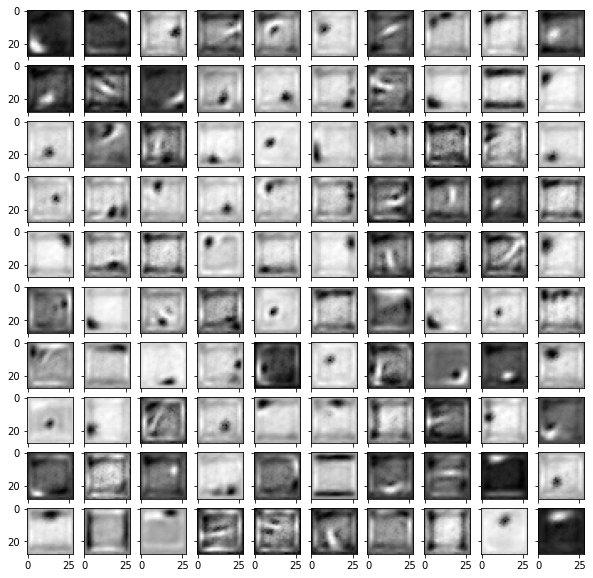

In [ ]:
# Print weights layer 5

#Extract weigths
learned_weights_layer_1 = dbn_emnist.rbm_layers[0].W.numpy()
learned_weights_layer_2 = dbn_emnist.rbm_layers[1].W.numpy()
learned_weights_layer_3 = dbn_emnist.rbm_layers[2].W.numpy()
learned_weights_layer_4 = dbn_emnist.rbm_layers[3].W.numpy()
learned_weights_layer_5 = dbn_emnist.rbm_layers[4].W.numpy()

# Apply threshold to eliminate noise
learned_weights_layer_1 = _apply_threshold(learned_weights_layer_1, 0)
learned_weights_layer_2 = _apply_threshold(learned_weights_layer_2, 0)
learned_weights_layer_3 = _apply_threshold(learned_weights_layer_3, 0)
learned_weights_layer_4 = _apply_threshold(learned_weights_layer_4, 0)
learned_weights_layer_5 = _apply_threshold(learned_weights_layer_5, 0)

# Project back matrix in 28x28 space
learned_weights_product = (learned_weights_layer_1 @ learned_weights_layer_2 @ learned_weights_layer_3 @ learned_weights_layer_4 @ learned_weights_layer_5).T  # here we do the projection
learned_weights_product = _apply_threshold(learned_weights_product, 0)

_plot_layer_receptive_fields(learned_weights_product)

## Hierarchical clustering

In order to explore the properties of the hidden layer representations, we will cluster these internal representations and plot dendrogram. Hierarchical clustering groups similar features together. To see how close the classes are one to another, the centroid of the hidden layer representations will be computed. To properly inspect the network, the internal representations will be clustered at each level. The first layer input is the training dataset, while for each next hidden layer, the input is the hidden representation of the previously hidden layer. After extracting all hidden representations, the mean of those representations of each class is calculated and then the matrix that contains all the means is built. This matrix is used by the clustering algorithm to create the graph. Each branch on the plot represents the class, and the heights of the branches represent the time when the elements were grouped together. The most comparable elements were grouped early on which are on the lower parts of the dendrogram (they have shorter branches).

<br>

Looking at the dendrogram of the first hidden layer, we can see that it was the easiest to group together elements from classes 21, 1, and 18 (green on the left), where 18 and 1 have the shortest branch. Since 18 represents "I" and 21 represents "L", it is easy to see that they have similar features and that "I" is closer to "1" than "L" is. Next, classes 0 and 24 (black) were grouped together fast because they are extremely similar since class 24 represents the upper-case letter "O". The same reasoning is behind grouping first the classes 41 and 44 (red on the left) which represent letters "g" and "q". For the model, it was easy to group together the same upper-case and lower-case letters fast, such as classes 15 and 40 (red on the left) which represent "F" and "f" respectively. Also, classes 43 and 45 were grouped together later on, and it is easy to see why since they represent letters "n" and "r" which have a somewhat similar structure.

<br>

The second layer is similar to the previously hidden layer, but now classes 3 and 11 (green on the right) are in the separate cluster where class 11 represents "B". Second green group represents letters "M", "N", and "W" which have similar strokes. They were also recognized in the first layer, but the second layer took less time to group them together.

<br>

In the third layer, the only difference is that classes 21, 1, and 18 ("L", "1", and "I") are the group for themselves which was not the case in the previous layers.

<br>

The fourth and fifth hidden layers seem to have the same groups as the third hidden layers, but the only difference is in the height of the branches.

In [ ]:
# Extract representations

hidden_repr_layer_1 = _get_kth_layer_repr(emnist_data_train, 0)
hidden_repr_layer_2 = _get_kth_layer_repr(hidden_repr_layer_1, 1)
hidden_repr_layer_3 = _get_kth_layer_repr(hidden_repr_layer_2, 2)
hidden_repr_layer_4 = _get_kth_layer_repr(hidden_repr_layer_3, 3)
hidden_repr_layer_5 = _get_kth_layer_repr(hidden_repr_layer_4, 4)

In [ ]:
# Calculate the mean of hidden representations

label_to_mean_hidd_repr_1 = _get_label_to_mean_hidd_repr(hidden_repr_layer_1)
label_to_mean_hidd_repr_2 = _get_label_to_mean_hidd_repr(hidden_repr_layer_2)
label_to_mean_hidd_repr_3 = _get_label_to_mean_hidd_repr(hidden_repr_layer_3)
label_to_mean_hidd_repr_4 = _get_label_to_mean_hidd_repr(hidden_repr_layer_4)
label_to_mean_hidd_repr_5 = _get_label_to_mean_hidd_repr(hidden_repr_layer_5)

In [ ]:
# Build matrix containing all the means

mean_hidd_repr_matrix_1 = _get_hidden_reprs_matrix(label_to_mean_hidd_repr_1)
mean_hidd_repr_matrix_2 = _get_hidden_reprs_matrix(label_to_mean_hidd_repr_2)
mean_hidd_repr_matrix_3 = _get_hidden_reprs_matrix(label_to_mean_hidd_repr_3)
mean_hidd_repr_matrix_4 = _get_hidden_reprs_matrix(label_to_mean_hidd_repr_4)
mean_hidd_repr_matrix_5 = _get_hidden_reprs_matrix(label_to_mean_hidd_repr_5)

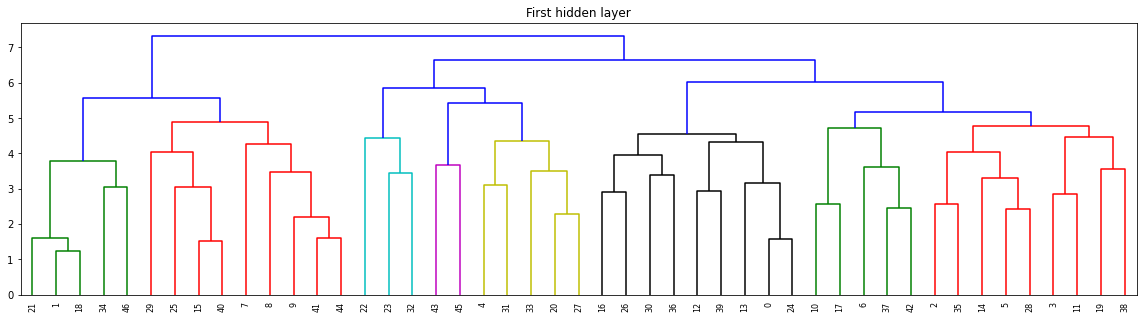

In [ ]:
_plot_dendrogram(mean_hidd_repr_matrix_1, "First hidden layer")

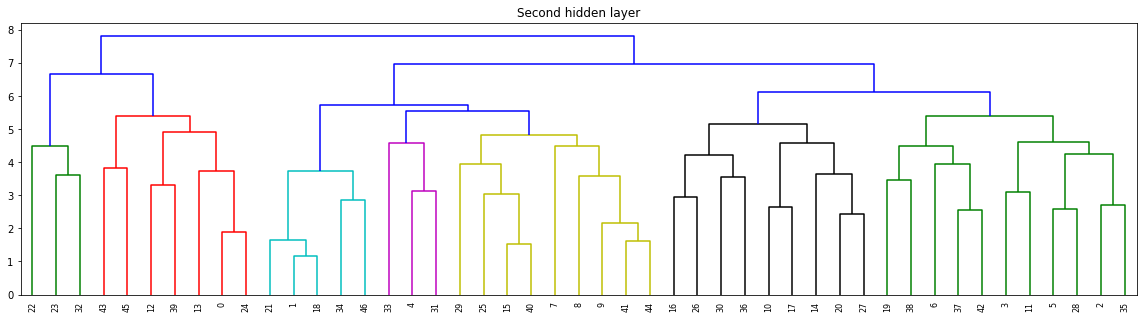

In [ ]:

_plot_dendrogram(mean_hidd_repr_matrix_2, "Second hidden layer")

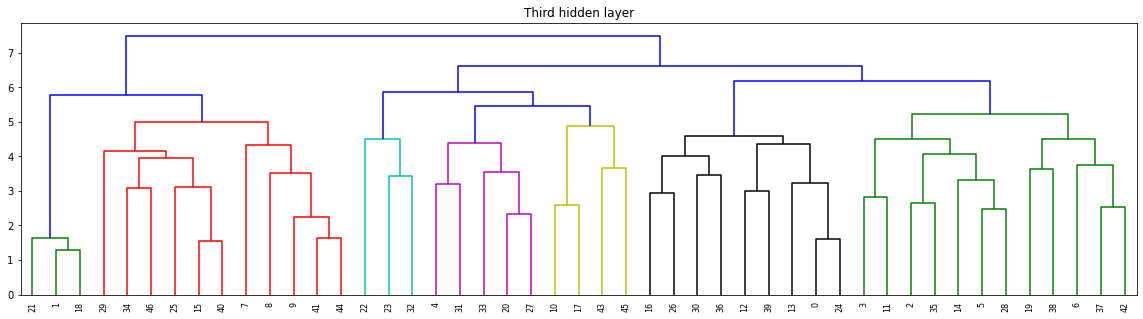

In [ ]:
_plot_dendrogram(mean_hidd_repr_matrix_3, "Third hidden layer")

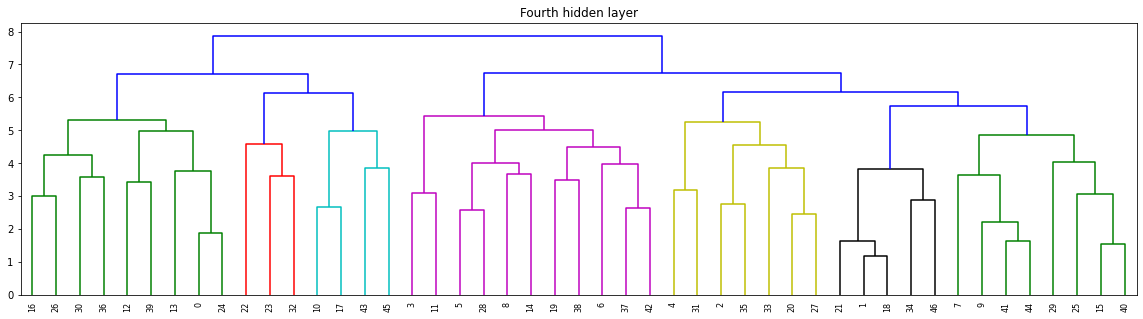

In [ ]:
_plot_dendrogram(mean_hidd_repr_matrix_4, "Fourth hidden layer")

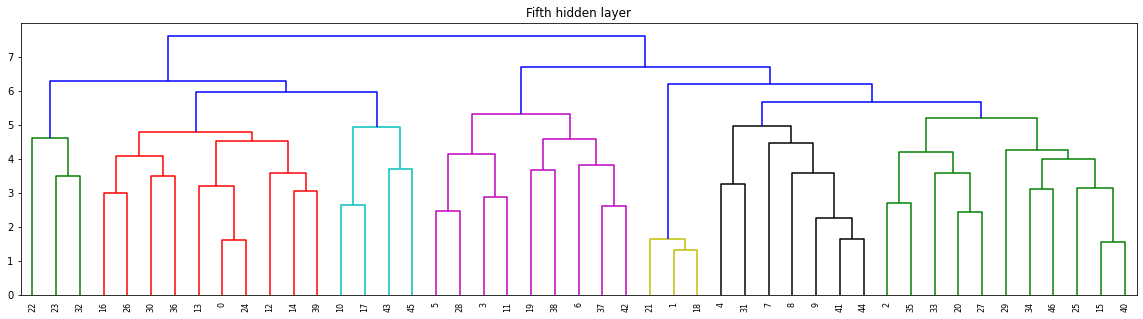

In [ ]:
_plot_dendrogram(mean_hidd_repr_matrix_5, "Fifth hidden layer")

## Linear read-out

Linear read-out represents another way to determine how distinct the representations from hidden layers are. The representations produced by the trained model are used on the test set to produce the representations. Also, the simple linear classifier is created to classify the original images and assess their accuracy. The last layer read-out is more important because it should be more descriptive. To see if representations become more disentangled at the different layers in the network I will compare the last two hidden layers. The loss at the 4th hidden layer is higher with the value of 1.37 while the last layer has a much smaller loss of 1.29. This proves that representation becomes more disentangled at the last layer than it is at the previously hidden layers.

In [ ]:
last_layer_size = dbn_emnist.rbm_layers[-1].W.shape[0]

class Perceptron(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = torch.nn.Linear(last_layer_size, 47)

  def forward(self, x):
    return self.linear(x)

In [ ]:
perceptron = Perceptron()

In [ ]:
optimizer = torch.optim.SGD(perceptron.parameters(), lr=0.05)
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 1000

# Layer 4
for epoch in range(epochs):
  optimizer.zero_grad()
  predictions = perceptron(hidden_repr_layer_4).squeeze()
  targets = emnist_targets_train.reshape(predictions.shape[0])
  loss = loss_fn(predictions, targets)
  loss.backward()
  optimizer.step()

  print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/1000, loss = 3.866486
epoch : 2/1000, loss = 3.852837
epoch : 3/1000, loss = 3.839316
epoch : 4/1000, loss = 3.825917
epoch : 5/1000, loss = 3.812634
epoch : 6/1000, loss = 3.799464
epoch : 7/1000, loss = 3.786403
epoch : 8/1000, loss = 3.773446
epoch : 9/1000, loss = 3.760591
epoch : 10/1000, loss = 3.747834
epoch : 11/1000, loss = 3.735174
epoch : 12/1000, loss = 3.722606
epoch : 13/1000, loss = 3.710129
epoch : 14/1000, loss = 3.697741
epoch : 15/1000, loss = 3.685439
epoch : 16/1000, loss = 3.673222
epoch : 17/1000, loss = 3.661088
epoch : 18/1000, loss = 3.649034
epoch : 19/1000, loss = 3.637062
epoch : 20/1000, loss = 3.625167
epoch : 21/1000, loss = 3.613349
epoch : 22/1000, loss = 3.601608
epoch : 23/1000, loss = 3.589940
epoch : 24/1000, loss = 3.578347
epoch : 25/1000, loss = 3.566826
epoch : 26/1000, loss = 3.555377
epoch : 27/1000, loss = 3.543999
epoch : 28/1000, loss = 3.532690
epoch : 29/1000, loss = 3.521451
epoch : 30/1000, loss = 3.510280
epoch : 31/1000, lo

In [ ]:
# Layer 5
for epoch in range(epochs):
  optimizer.zero_grad()
  predictions = perceptron(hidden_repr_layer_5).squeeze()
  targets = emnist_targets_train.reshape(predictions.shape[0])
  loss = loss_fn(predictions, targets)
  loss.backward()
  optimizer.step()

  print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/1000, loss = 4.061296
epoch : 2/1000, loss = 4.042779
epoch : 3/1000, loss = 4.024626
epoch : 4/1000, loss = 4.006815
epoch : 5/1000, loss = 3.989329
epoch : 6/1000, loss = 3.972150
epoch : 7/1000, loss = 3.955264
epoch : 8/1000, loss = 3.938653
epoch : 9/1000, loss = 3.922308
epoch : 10/1000, loss = 3.906214
epoch : 11/1000, loss = 3.890362
epoch : 12/1000, loss = 3.874740
epoch : 13/1000, loss = 3.859340
epoch : 14/1000, loss = 3.844153
epoch : 15/1000, loss = 3.829171
epoch : 16/1000, loss = 3.814386
epoch : 17/1000, loss = 3.799791
epoch : 18/1000, loss = 3.785379
epoch : 19/1000, loss = 3.771145
epoch : 20/1000, loss = 3.757083
epoch : 21/1000, loss = 3.743186
epoch : 22/1000, loss = 3.729450
epoch : 23/1000, loss = 3.715870
epoch : 24/1000, loss = 3.702442
epoch : 25/1000, loss = 3.689161
epoch : 26/1000, loss = 3.676022
epoch : 27/1000, loss = 3.663022
epoch : 28/1000, loss = 3.650158
epoch : 29/1000, loss = 3.637426
epoch : 30/1000, loss = 3.624822
epoch : 31/1000, lo

## Evaluation

The accuracy is calculated by the function _compute_accuracy. This function computes the accuracy by looking at the total number of test labels and the number of correctly predicted classes. For the sake of comparison, I show below the accuracy of the last two hidden layers to show the progress that the model makes. The accuracy on the last layer is higher for more than 5% from the previously hidden layer which proves that the accuracy of the classifier improves when we go up in the hierarchy of the model.

<br>

To see the kind of errors that the model makes, I will create a confusion matrix which is quite big in this case because there are 47 classes. The matrix will be computed on the testing results. It seems that makes errors when it comes to the elements that have the most similar features. Another mistake comes from the misclassification of upper and lower case letters. If we look at the scores, the highest scores have classes that were grouped together fastest as was shown on dendrogram plots. For example, letters "I", "L", and number "1" as well as letter "O" and number "0". Another interesting example that was not grouped fast in dendrogram would be the classes 9 and 44, which correspond to number 9 and the letter "q". According to dendrograms, the number 9 was firstly grouped with the letter "g". When it comes to upper and lower case letters, the highest score has classes 15 and 40 (letters "f" and "F").

In [ ]:
# Extract hidden representations

hidden_repr_layer_1_test = _get_kth_layer_repr(emnist_data_test, 0)
hidden_repr_layer_2_test = _get_kth_layer_repr(hidden_repr_layer_1_test, 1)
hidden_repr_layer_3_test = _get_kth_layer_repr(hidden_repr_layer_2_test, 2)
hidden_repr_layer_4_test = _get_kth_layer_repr(hidden_repr_layer_3_test, 3)
hidden_repr_layer_5_test = _get_kth_layer_repr(hidden_repr_layer_4_test, 4)

In [ ]:
# compare predicted class to the original lable on layer 4

predictions_test = perceptron(hidden_repr_layer_4_test)
acc = _compute_accuracy(predictions_test, emnist_targets_test)
print("The accuracy of the 4th hidden layer is: ", acc)

The accuracy of the 4th hidden layer is:  0.6107000112533569


In [ ]:
# compare predicted class to the original lable on layer 5

predictions_test= perceptron(hidden_repr_layer_5_test)
acc = _compute_accuracy(predictions_test, emnist_targets_test)
print("The accuracy of the last hidden layer is: ", acc)

The accuracy of the last hidden layer is:  0.6729000210762024


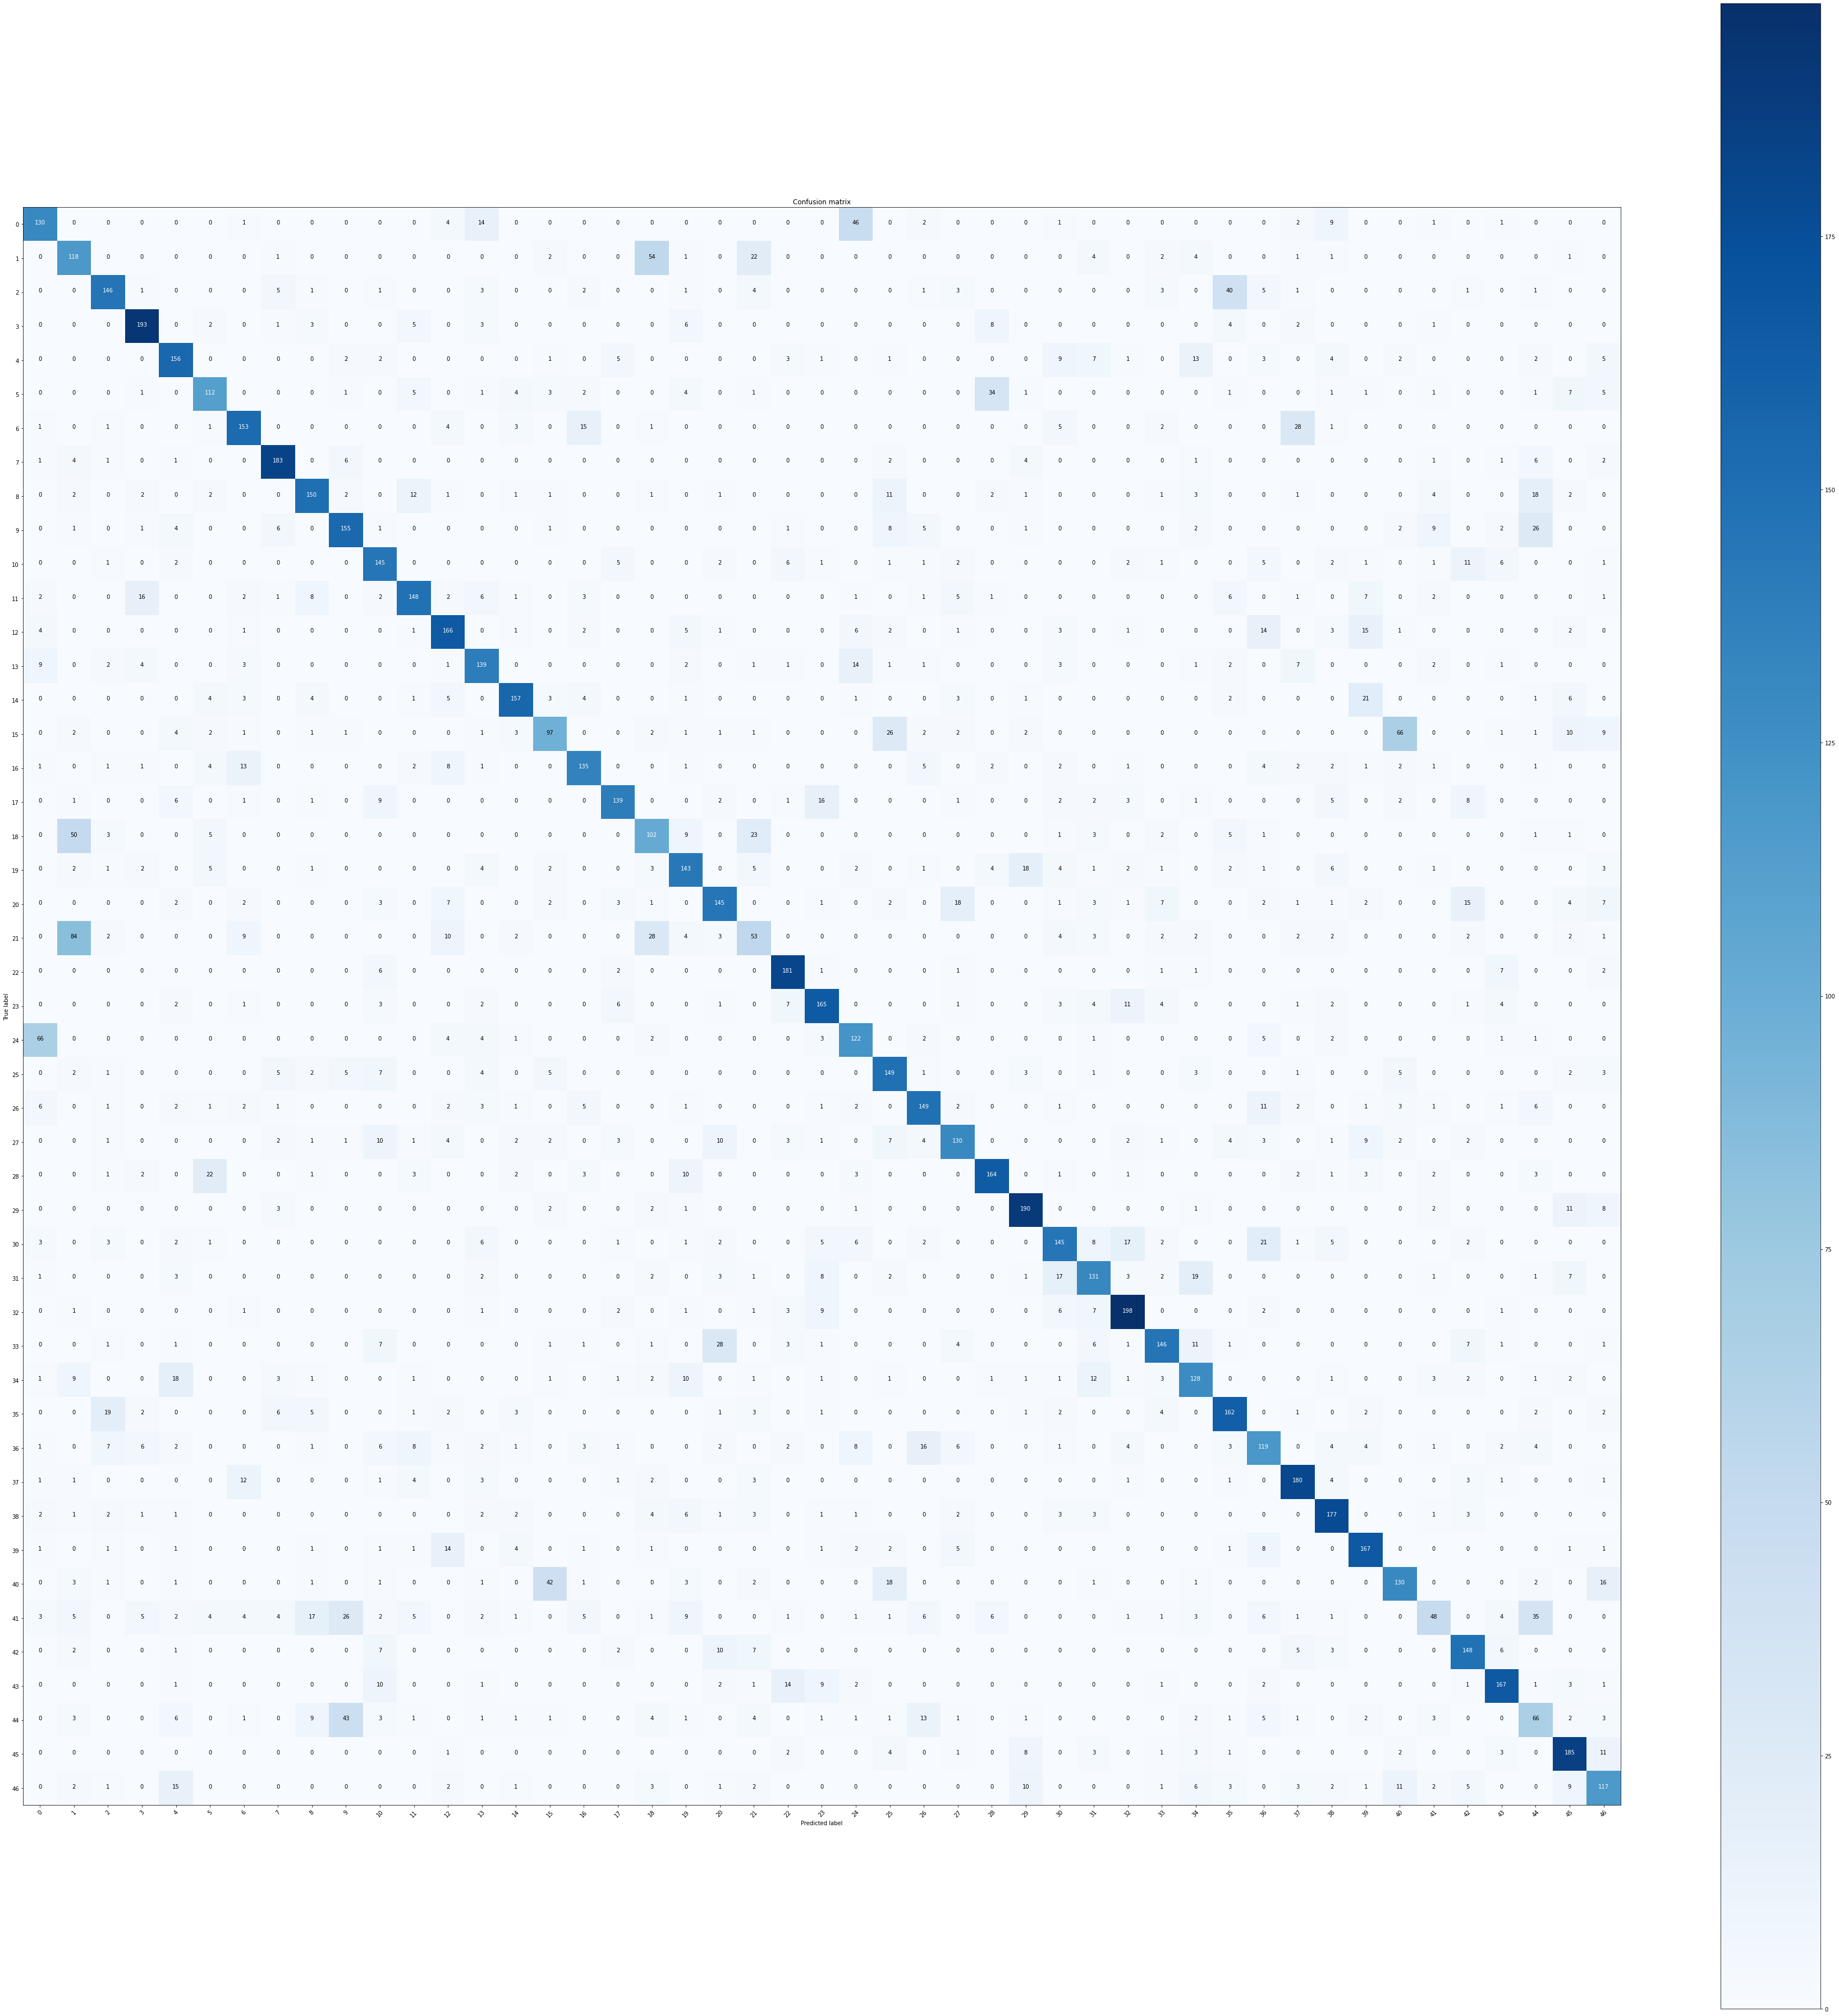

In [ ]:
num_classes = 47

# Create confusion matrix layer 5

predictions_test = predictions_test.detach().numpy()
confusion_mtx = confusion_matrix(emnist_targets_test, np.argmax(predictions_test,axis = 1) )
plot_confusion_matrix(confusion_mtx, classes = range(num_classes))

#  Conclusion

To conclude, the purpose of this project was to explore how the model learns to represent the data. After visualizing the data and the classes, models with different parameters were tested to see which one has the best performance through the given task of the classification. The parameters that were considered were the number of layers, number of hidden units, initial momentum, final momentum, and learning rate. During the fine-tuning phase, the accuracy and loss of the classifier that was trained on the last hidden layer representation were monitored. The model that scored the highest score of 67.85% was DBN using 5 hidden layers. It was trained and tested on the balanced EMNIST dataset which contains letter and digits images represented by 28x28 pixels. Through feature visualization, it can be seen what kind of features were learned at each layer and what particular features activated the neurons. With hierarchical clustering, we saw what classes were grouped together and at what pace; furthermore, the classes that had the most similar features were grouped together with the fastest. The linear readouts show that hidden representations become less entangled at deeper levels of the network. Finally, the confusion matrix showed that the model made most errors with the classes that have extremely similar features and symbols that have very similar shapes.

# References

*emnist | TensorFlow Datasets*. (n.d.). TensorFlow. https://www.tensorflow.org/datasets/catalog/emnist#emnistmnist

*EMNIST (Extended MNIST)*. (2017, December 20). Kaggle. https://www.kaggle.com/crawford/emnist

Singh, H. (2021, April 11). *Deep Belief Networks — An Introduction - Black Feathers University*. Medium. https://medium.com/black-feathers-labs/deep-belief-networks-an-introduction-1d52bb867a25

S. (2019, October 9). Guide to t-SNE machine learning algorithm implemented in R & Python. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2017/01/t-sne-implementation-r-python/

Jaadi, Z. (2021, December 1). A Step-by-Step Explanation of Principal Component Analysis (PCA). Built In. https://builtin.com/data-science/step-step-explanation-principal-component-analysis

*Visualizing Datasets*. (n.d.). The Data Frog. https://thedatafrog.com/en/articles/visualizing-datasets/

E. (2021, April 2). Using MNIST model for EMNIST 89% w/Keras. Kaggle. https://www.kaggle.com/emmanuelmess/using-mnist-model-for-emnist-89-w-keras#4.-Evaluate-the-model